In [ ]:
"""reference by andrej kaparthy youtube video"""

a=1
b=2
a*b
import torch
import math
import matplotlib.pyplot as plt
import random

In [ ]:
import math


class Value:


  def __init__(self, data,children=(),op='',label =''):
      self.data = data
      self.prev = set(children)  #이전 값을 모두저장
      self.op = op
      self._backward = lambda: None
      self.label = label
      self.grad = 0

  def __repr__(self):
    return f"값(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), op = "+")

  # 덧셈의 derivitive 는 항상 1임으로 영항 x
    def _backward():
      self.grad += 1.0* out.grad
      other.grad += 1.0* out.grad         # += 이유 1개의 뉴런에 2개 이상의 뉴런의 값이 주어지면 overwrite됨
    out._backward = _backward             #accumulate all of gradients
    return out                            #_backward 진짜 backward x



  def __radd__(self, other):
      return self + other

  def __neg__(self):
      return self * -1

  def __sub__(self, other):
      return self + (-other)

  def __rsub__(self, other):
      return (-self) + other

  # if a*b =c  dc/da = b , ax = y, dy/dx = a 두변수 곱셈의 미분값은 다른변수값

#int와 value값을 못곱하는 경우
  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), op = "*")

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out

  def __rmul__(self,other):   #a.__mul__(2)
                              #2.__mul__(a)
    return self * other

  def __pow__(self, other):
      assert isinstance(other, (int, float))                           #지수함수 other가 지수
      out = Value(self.data ** other, (self,), op = f"**{other}")

      def _backward():
          self.grad += (self.data ** (other - 1)) * other * out.grad
      out._backward = _backward

      return out

  def tanh(self):                 #t = tanh(x)
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x) +1)   #tanh 함수
    out = Value(t, (self,),op="tanh")             #activation 함수

    def _backward():                   #tanh의 backpropagation gradient descent 함수
      self.grad += (1-t**2) * out.grad   #tanh 미분값 = 1 - tanh^2 , 체인룰
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()  # 모든 edges directed to left or right - 위상정렬
    def build_topo(v):   # 재귀적으로 진행 밑의 trace와 비슷하게 작동
      if v not in visited:  #목적 순차적으로 정렬
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0                 #역전파 시작될 때 초기 gradient 를 1로 설정
    for node in reversed(topo):     #topo 역순으로 모든 gradient 구함 _backward() 한꺼번에
      node._backward()


A= Value(4.0)
B= Value(6.0)
C= Value(3.0)
D= A*B+C
D


값(data=27.0)

In [ ]:
A.__add__(C)

값(data=7.0)

In [ ]:
D.prev

{값(data=24.0), 값(data=3.0)}

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes,edges = set(),set()
  def build(v):                   # v = value
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))       # build(root)로 root 를 v로 -> if root = D라면
        build(child)                # nodes에 D가 없으므로 {D}로 추가하고 D.prev 의 ((A*B),(C))의 children
  build(root)                       # 호출해 edges 에 추가 후 (A,B),C에 대해 재귀적으로 이 작업 반복
  return nodes, edges               # nodes에 A,B,C 모두 존재하게되면 작업을끝내고 완성된 nodes,edges 반환

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))                  # n의 메모리 주소의 문자열
    dot.node(name= uid,label="{ %s | data %.4f | grad %.4f }"%(n.label,n.data,n.grad) , shape ='record' )
    if n.op :                                                         #dot.node, dot.edge;
      dot.node(name= uid + n.op,label = n.op)                         #Digraph class 에 속하는 내장함수를 사용함
      dot.edge(uid + n.op,uid)                                        #시각화를 위한 함수

  for n1, n2 in edges:
     dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

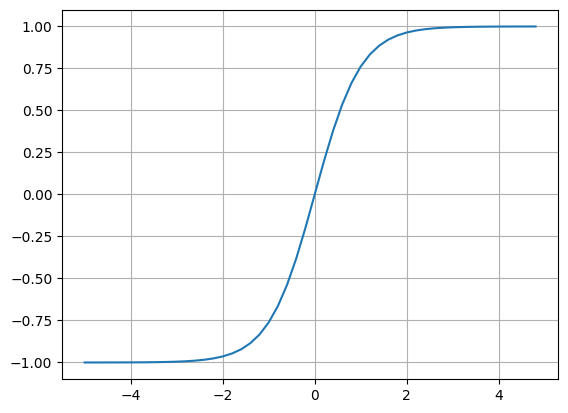

In [ ]:
import matplotlib.pyplot as plt  #tanh graph 시각화
import numpy as np
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid()

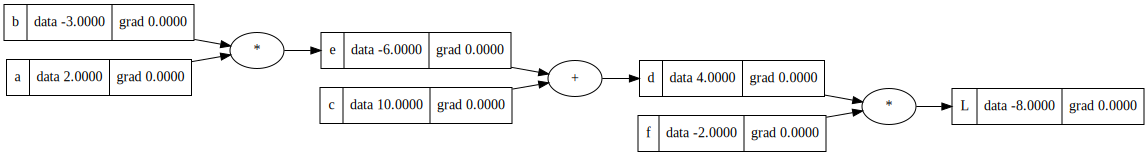

In [ ]:
a = Value(2.0,label ="a")
b = Value(-3.0,label= "b")
c= Value(10.0,label = "c")
f= Value(-2.0,label ='f')
e=a*b; e.label = 'e'
d= e+c; d.label= 'd'
L = d*f; L.label ="L"
draw_dot(L)

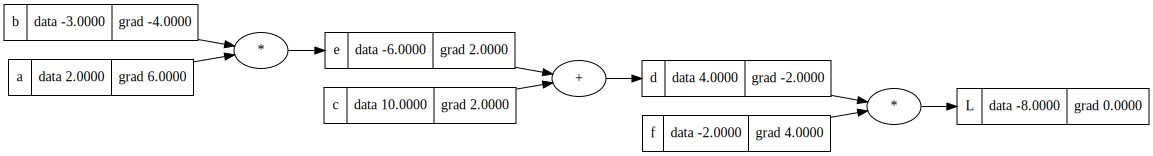

In [ ]:
# @title grad derivitive

#chain rule 사용           -2       1
#example = dL / de =   dL / dd * dd/de
e.grad = 2.0
# a.grad = dL / da = dL / dd * dd/de * de/da =  6
a.grad = 6.0
b.grad = -4.0
c.grad = 2.0
d.grad = -2.0
f.grad = 4.0
draw_dot(L)

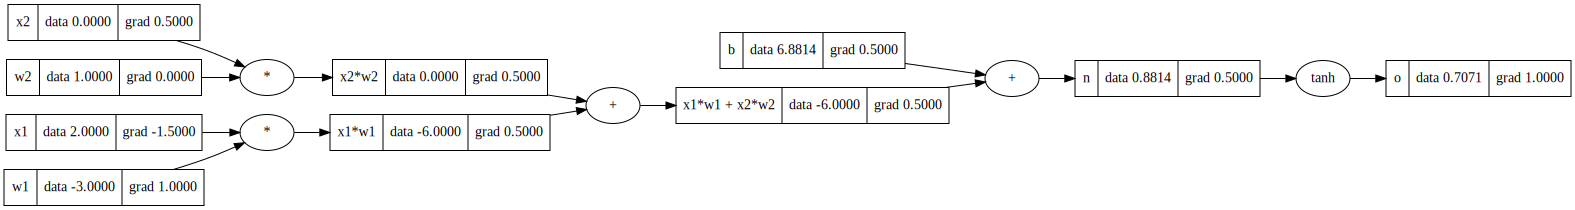

In [ ]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')  #value의 이유 : do/dn 의 값을 0.5로 맞추기위해
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.grad = 1.0
o.backward()
draw_dot(o) #o = tanh(n), do/dn = 1-tanh(n)^2 = 1-o^2

In [ ]:
import torch
import random

class Neuron:

  def __init__(self, nin): #constructor, nin = number of inputs
    self.w = [Value(random.uniform(-1,1)) for i in range(nin)]  #list 인이유 = matrix multiplication
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):                  #example: x =[10,2], n=Neuron(2)
    # w * x + b                                   # n(x) <-- __call__
    #모든 weight,input,bias처리
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()           #non-linearty
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

     #  x =[10,2]  |  n=Layer(2,3)  |  n(x)=  value 3개 list

  def __init__(self, nin, nout):   #nout = numbers of output
    self.neurons = [Neuron(nin) for _ in range(nout)]
    ##for _ in range(nout) 의미 : output neuron당 input neuron의 모든 node연결

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    # multi layer perceptron 다층 퍼셉트론
    # x= [2.0,3.0,-1.0]  |  n = MLP(3, [4,4,1])  | n(x)


  def __init__(self, nin, nouts):
    size = [nin] + nouts
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [Value(2.0, label = "x1"), Value(3.0, label = "x2"),Value(4, label = "x3")]
n = MLP(2, [3,2,1])
n(x)
print(len(n.parameters()))
n.parameters()

20


[값(data=0.030861141751192145),
 값(data=0.4377111819518533),
 값(data=0.5625892644389292),
 값(data=0.6752421249213074),
 값(data=0.1250718320075388),
 값(data=-0.049438052803762345),
 값(data=0.31034165017429727),
 값(data=0.005784303368290944),
 값(data=0.7936445051297412),
 값(data=0.24080703023196803),
 값(data=-0.9724926864005607),
 값(data=0.9615147618636983),
 값(data=0.06794294679968815),
 값(data=0.161710722026984),
 값(data=0.26448995627289307),
 값(data=-0.44910090452694695),
 값(data=0.3322083445304529),
 값(data=0.9397199606281164),
 값(data=-0.6299602051626172),
 값(data=-0.26807719844994815)]

In [ ]:
n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


[값(data=-0.372577124436342),
 값(data=-0.2610339446529574),
 값(data=-0.7491635197197393),
 값(data=-0.011460398489358673)]

In [ ]:
for k in range(20):

  # forward pass

  y_pred = [n(x) for x in xs]

  #backward pass #mse 사용

  loss = sum((yout - ygt)**2 for yout,ygt in zip(ys,y_pred))  #ygt = y groundtruth = 예측값
  loss.backward()

  #update,최적화과정

  for p in n.parameters():  #0.01 = learning rate
    p.data += -0.01 *p.grad

In [ ]:
n.layers[0].neurons[0].w[0].grad

8.395293620969294

In [ ]:
y_pred # ys = [1.0,-1.0,-1.0,1.0] #비슷해짐

[값(data=0.7068796170104451),
 값(data=-0.9999370792900824),
 값(data=-0.9999744220881611),
 값(data=0.9889492438575421)]

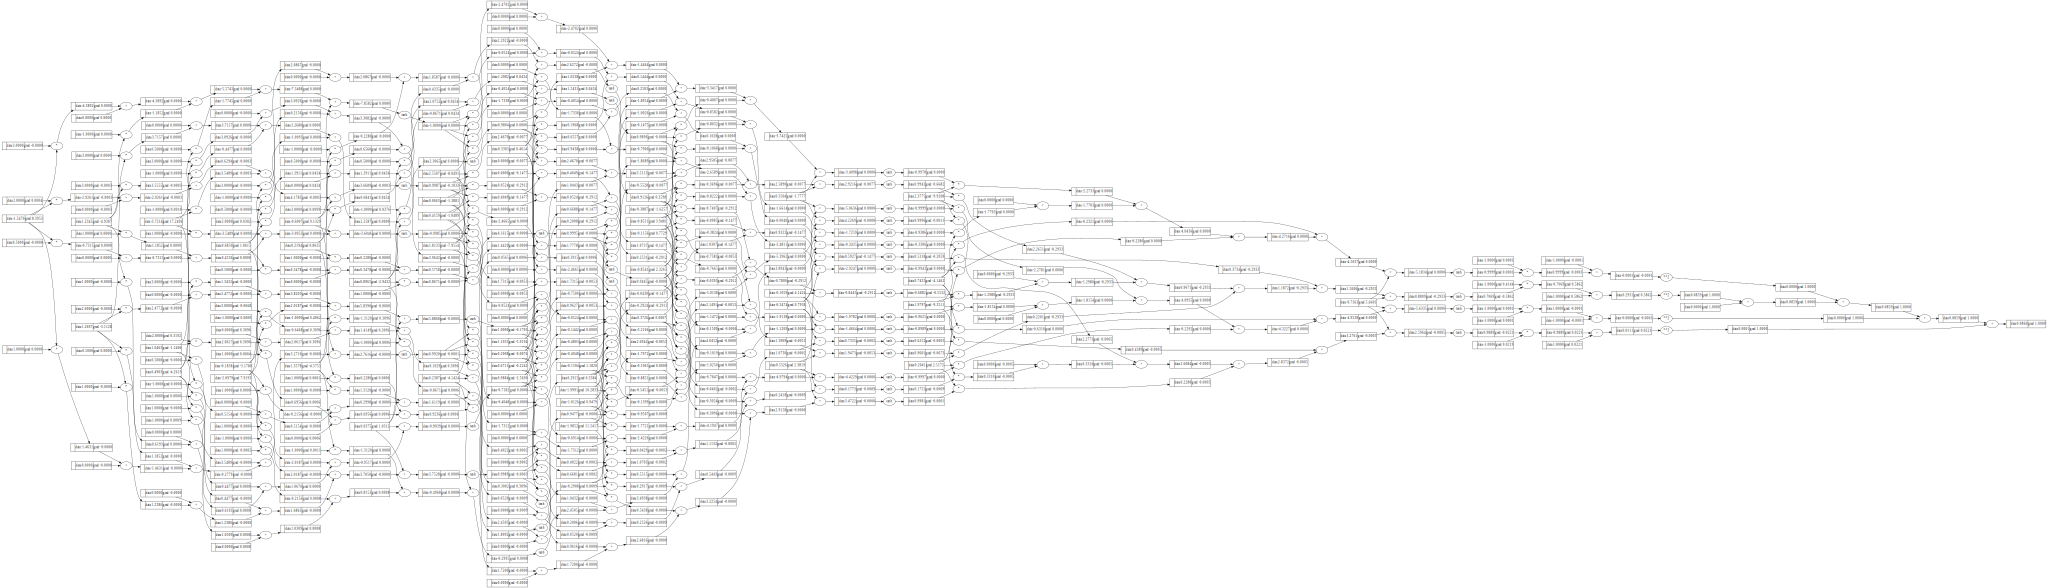

In [ ]:
draw_dot(loss)